In [1]:
import numpy as np
import pandas as pd

import copy

import random
from random import randrange
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
x_columns = ['GrLivArea', 'YearBuilt']
y_column = ['SalePrice']

X_columns = pd.DataFrame(df_train, columns=x_columns)
y_saleprice = pd.DataFrame(df_train, columns=y_column)

df = pd.concat([X_columns, y_saleprice], axis=1)

In [4]:
df.shape

(1460, 3)

- 前処理・訓練データと検証データの分割

In [5]:
X = df[x_columns].values
y = df[y_column].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80)

- 前処理・標準化

In [7]:
scaler = StandardScaler()

In [8]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
X_train_scaled = scaler.transform(X_train)

In [10]:
X_test_scaled = scaler.transform(X_test)

### 【問題1】ブレンディングのスクラッチ実装
ブレンディング をスクラッチ実装し、単一モデルより精度があがる例を 最低3つ 示してください。精度があがるとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを指します。


ブレンディングとは
ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。


- 手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
- ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
- 入力データの前処理の仕方（例：標準化、対数変換、PCAなど）

重要なのはそれぞれのモデルが大きく異なることです。


回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。


《補足》


分類問題の場合は、多数決を行います。回帰問題に比べると複雑なため、scikit-learnにはVotingClassifierが用意されています。


[sklearn.ensemble.VotingClassifier — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [11]:
class BlendModel():
    """
    アンサンブル学習：ブレンディングのスクラッチ実装

    Parameters
    ----------
    estimators : list of (str, estimator) tuples

    Attributes
    ----------
    self._estimators : 学習済モデルのインスタンスのリスト
    """    
    def __init__(self, estimators, weights=[]):
        # ハイパーパラメータを属性として記録
        self.estimators = estimators
        self.weights = weights
        
    def fit(self, X, y):
        """
        N個の多様なモデルを独立して学習
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        _estimators = []
        for index, model in enumerate(self.estimators):
            fit_model = copy.deepcopy(model) #クラス外で作成したモデルのインスタンスを使用すると、エラーが発生するため再定義
            fit_model[1].fit(X, y)
            _estimators.append(fit_model)
            
        self._estimators = _estimators
            
    def predict(self, X):
        """
        N個の多様な学習済モデルを使い推定
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            テストデータの特徴量
            
        Returns
        -------
        y_hut
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        pred_list = []
        for index in range(len(self.estimators)):
            pred_list.append(self._estimators[index][1].predict(X))

        if len(self.weights) == 0:
            ensemble_pred = np.sum(np.array(pred_list), axis=0) / len(self.estimators)
        else:
            temp = []
            for index in range(len(self.weights)):
                temp.append(np.array(pred_list).T[:, index] * self.weights[index] / sum(self.weights))
                ensemble_pred = np.sum(np.array(temp), axis=0)
        
        return ensemble_pred

- パターン1 重さ(weights=[5, 1, 4])

In [12]:
lr_model = LinearRegression()
svm_model = SVR()
dt_model = DecisionTreeRegressor()

blending = BlendModel(estimators=[('lr', lr_model), ('svm', svm_model), ('dt', dt_model)], weights=[5, 1, 4])
blending.fit(X_train_scaled, y_train.ravel())
ensemble_pred = blending.predict(X_test_scaled)

In [13]:
print("Mean Squared Error: {:,.5f}".format(metrics.mean_squared_error(y_test, ensemble_pred)))

Mean Squared Error: 1,757,967,385.96769


In [14]:
def residual_plots(y_test, y_pred):
    # テスト用データの残差プロット
    plt.scatter(y_pred[:, np.newaxis], (y_pred[:, np.newaxis] - y_test), c='b', alpha=0.5)

    # y=0の水平線
    #plt.hlines(y=0,xmin=min(y_pred),xmax=max(y_pred), color='black')
    plt.hlines(y=0,xmin=50000,xmax=600000, color='black')

    plt.title('Residual Plots')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid()

    plt.show()

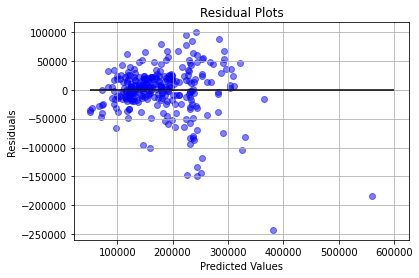

In [15]:
residual_plots(y_test, ensemble_pred)

- パターン2 対数変換、重さ無し

In [16]:
df['GrLivArea_Log'] = df['GrLivArea'].apply(np.log)
df['SalePrice_Log'] = df['SalePrice'].apply(np.log)

In [17]:
x_columns_log = ['GrLivArea_Log', 'YearBuilt']
X_log = df[x_columns_log].values
y_log = df['SalePrice_Log'].values

In [18]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, train_size=0.80)

- 前処理・標準化

In [19]:
scaler = StandardScaler()
scaler.fit(X_train_log)
X_train_scaled_log = scaler.transform(X_train_log)
X_test_scaled_log = scaler.transform(X_test_log)

In [20]:
lr_model = LinearRegression()
svm_model = SVR()
dt_model = DecisionTreeRegressor()

blending = BlendModel(estimators=[('lr', lr_model), ('svm', svm_model), ('dt', dt_model)])
blending.fit(X_train_scaled_log, y_train_log.ravel())
ensemble_pred = blending.predict(X_test_scaled_log)

In [21]:
ensemble_pred = np.exp(ensemble_pred)
y_test_log = np.exp(y_test_log)

In [22]:
print("Mean Squared Error: {:,.5f}".format(metrics.mean_squared_error(y_test_log, ensemble_pred)))

Mean Squared Error: 1,810,791,149.33432


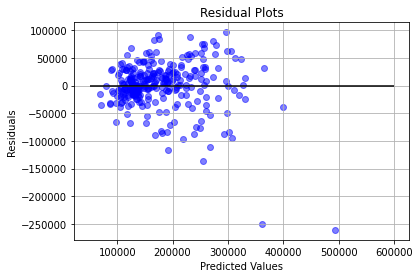

In [23]:
residual_plots(y_test_log.reshape(-1, 1), ensemble_pred)

- パターン3 モデル：線形回帰、決定木、ランダムフォレスト 

In [24]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100)
dt_model = DecisionTreeRegressor()

blending = BlendModel(estimators=[('lr', lr_model), ('rf', rf_model), ('dt', dt_model)])
blending.fit(X_train_scaled, y_train.ravel())
ensemble_pred = blending.predict(X_test_scaled)

In [25]:
print("Mean Squared Error: {:,.5f}".format(metrics.mean_squared_error(y_test, ensemble_pred)))

Mean Squared Error: 1,641,803,658.79407


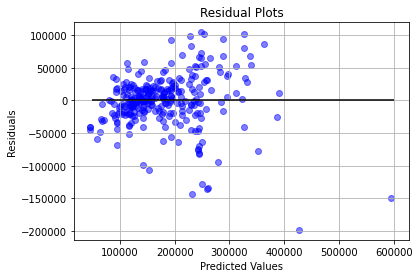

In [26]:
residual_plots(y_test.reshape(-1, 1), ensemble_pred)

- 単一モデル LinearRegression

In [27]:
lr_test_model = LinearRegression()
lr_test_model.fit(X_train_scaled, y_train.ravel())
lr_pred = lr_test_model.predict(X_test_scaled)

In [28]:
print("Mean Squared Error: {:,.5f}".format(metrics.mean_squared_error(y_test, lr_pred)))

Mean Squared Error: 1,978,262,647.39397


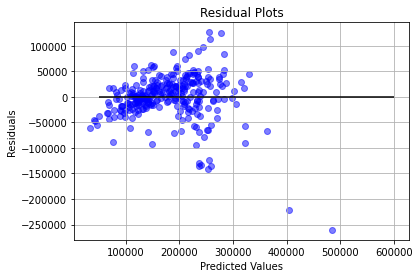

In [29]:
residual_plots(y_test, lr_pred)

### 【問題2】バギングのスクラッチ実装
バギング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。


バギングとは
バギングは入力データの選び方を多様化する方法です。学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ ブートストラップサンプル ）を作り出します。それらによってモデルをN個学習し、推定結果の平均をとります。ブレンディングと異なり、それぞれの重み付けを変えることはありません。


[sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)


scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができます。これによりブートストラップサンプルが手に入ります。


推定結果の平均をとる部分はブースティングと同様の実装になります。

In [30]:
class BaggingModel():
    """
    アンサンブル学習：バギングのスクラッチ実装

    Parameters
    ----------
    estimators : list of (str, estimator) tuples
    n_subsets : int
    
    Attributes
    ----------
    self._estimators : 学習済モデルのインスタンスのリスト
    self.n_subsets : N種類のサブセット（ ブートストラップサンプル ）
    """    
    def __init__(self, estimators, n_subsets):
        # ハイパーパラメータを属性として記録
        self.estimators = estimators
        self.n_subsets = n_subsets
        
    def fit(self, X, y):
        """
        N個の多様なモデルを独立して学習
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        _estimators = []
        fit_model = copy.deepcopy(self.estimators) 

        for subset in range(self.n_subsets):
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, train_size=0.80, shuffle=True)
            fit_model[1].fit(self.X_train, self.y_train)
            _estimators.append(fit_model)
            
        self._estimators = _estimators
            
    def predict(self, X):
        """
        N個の多様な学習済モデルを使い推定
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            テストデータの特徴量
            
        Returns
        -------
        y_hut
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        #print(self.y_test.shape)
        pred_list = []
        for index in range(self.n_subsets):
            pred_list.append(self._estimators[index][1].predict(self.X_test))

        bagging_pred = np.sum(np.array(pred_list), axis=0) / self.n_subsets
      
        return bagging_pred

- 前処理・標準化

In [31]:
scaler = StandardScaler()

In [32]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [33]:
X_scaled = scaler.transform(X)

In [34]:
dt_model = DecisionTreeRegressor()
bagging = BaggingModel(estimators=('dt', dt_model), n_subsets=10)
bagging.fit(X_scaled, y.ravel())
bagging_pred = bagging.predict(X_scaled)

In [35]:
print("Mean Squared Error: {:,.5f}".format(metrics.mean_squared_error(bagging.y_test, bagging_pred)))

Mean Squared Error: 2,497,900,405.98554


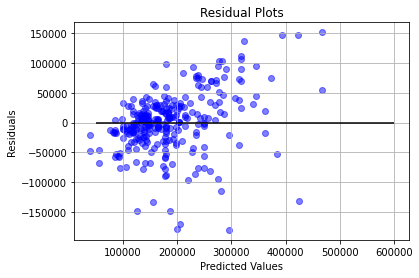

In [36]:
residual_plots(bagging.y_test.reshape(-1, 1), bagging_pred)

- 単一モデル LinearRegression

In [37]:
dt_test_model = DecisionTreeRegressor()
dt_test_model.fit(X_train_scaled, y_train.ravel())
dt_pred = dt_test_model.predict(X_test_scaled)

In [38]:
print("Mean Squared Error: {:,.5f}".format(metrics.mean_squared_error(y_test, dt_pred)))

Mean Squared Error: 2,556,038,751.57087


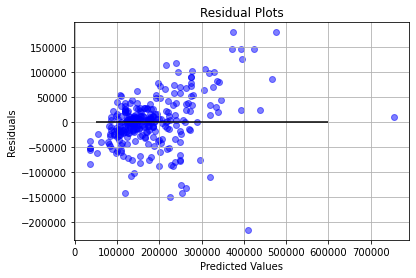

In [39]:
residual_plots(y_test, dt_pred)

### 【問題3】スタッキングのスクラッチ実装
スタッキング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。


スタッキングとは
スタッキングの手順は以下の通りです。最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装してください。まずは $K_0=3, M_0=2$ 程度にします。


《学習時》


（ステージ $0$ ）


- 学習データを $K_0$ 個に分割する。
- 分割した内の $(K_0 - 1)$ 個をまとめて学習用データ、残り $1$ 個を推定用データとする組み合わせが $K_0$ 個作れる。
- あるモデルのインスタンスを $K_0$ 個用意し、異なる学習用データを使い学習する。
- それぞれの学習済みモデルに対して、使っていない残り $1$ 個の推定用データを入力し、推定値を得る。（これをブレンドデータと呼ぶ）
- さらに、異なるモデルのインスタンスも $K_0$ 個用意し、同様のことを行う。モデルが $M_0$ 個あれば、 $M_0$ 個のブレンドデータが得られる。

（ステージ $n$ ）


- ステージ $n-1$ のブレンドデータを$M_{n-1}$ 次元の特徴量を持つ学習用データと考え、 $K_n$ 個に分割する。以下同様である。

（ステージ $N$ ）＊最後のステージ


- ステージ $N-1$ の $M_{N-1}$ 個のブレンドデータを$M_{N-1}$ 次元の特徴量の入力として、1種類のモデルの学習を行う。これが最終的な推定を行うモデルとなる。

《推定時》


（ステージ $0$ ）


- テストデータを $K_0×M_0$ 個の学習済みモデルに入力し、$K_0×M_0$ 個の推定値を得る。これを $K_0$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $n$ ）


- ステージ $n-1$ で得たブレンドテストを $K_n×M_n$ 個の学習済みモデルに入力し、$K_n×M_n$ 個の推定値を得る。これを $K_n$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $N$ ）＊最後のステージ


- ステージ $N-1$ で得たブレンドテストを学習済みモデルに入力し、推定値を得る。

In [40]:
class StackingModel():
    """
    アンサンブル学習：スタッキングのスクラッチ実装

    Parameters
    ----------
    estimators : list of (str, estimator) tuples
    n_subsets : int

    Attributes
    ----------
    self._estimators : 学習済モデルのインスタンスのリスト
    self.n_subsets : N種類のサブセット（ ブートストラップサンプル ）
    """    
    def __init__(self, estimators, n_splits):
        # ハイパーパラメータを属性として記録
        self.estimators = estimators
        self.n_splits = n_splits
        
    def fit_predict(self, X, y, X_val):
        """
        N個の多様なモデルを独立して学習・推論
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            テストデータの特徴量
        """
        n_samples = len(y)
        n_samples_index = np.arange(n_samples)
        split_index = np.array_split(n_samples_index, self.n_splits, axis=0)

        temp_blend_data = np.zeros(n_samples)
        self.blend_data = np.zeros([n_samples, len(self.estimators)])     
        
        # 学習フェーズ 学習
        self._estimators = []
        for index, model in enumerate(self.estimators): # モデル
            for i in range(self.n_splits): # 分割
                fit_model = copy.deepcopy(model)

                fit_index = np.delete(n_samples_index, split_index[i])
                X_train, X_test = X[fit_index, :], X[split_index[i]]
                y_train, y_test = y[fit_index, :], y[split_index[i]]

                fit_model[1].fit(X_train, y_train)
                self._estimators.append(fit_model)
                temp_blend_data[split_index[i]] = fit_model[1].predict(X_test).flatten()

            # ブレンドデータ
            self.blend_data[:, index] = temp_blend_data.flatten()

        # 学習フェーズ ラストステージ
        meta_model = LinearRegression()
        meta_model.fit(self.blend_data, y)

        # 推論フェーズ 推論
        pred_list = np.zeros([len(X_val), len(self._estimators)])
        meta_blend_model = np.zeros([len(X_val), len(self.estimators)])

        for index in range(len(self._estimators)):# モデル×分割数分の推論
            pred_list[:, index] = self._estimators[index][1].predict(X_val).flatten()

        # 推論フェーズ 平均
        for index, split in enumerate(range(self.n_splits, len(self._estimators)+1, self.n_splits)):
            meta_blend_model[:, index] = pred_list[:, :split].mean(axis=1)

        # 推論フェーズ ラストステージ
        stacking_pred = meta_model.predict(meta_blend_model)

        return stacking_pred            

In [41]:
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor()

stacking = StackingModel(estimators=[('lr', lr_model), ('dt', dt_model)], n_splits=3)
stacking_pred = stacking.fit_predict(X_train_scaled, y_train, X_test_scaled)

In [42]:
print("Mean Squared Error: {:,.5f}".format(metrics.mean_squared_error(y_test, stacking_pred)))

Mean Squared Error: 1,826,104,605.74734


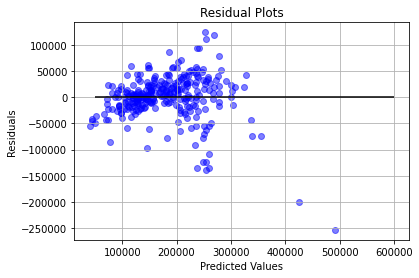

In [43]:
residual_plots(y_test, stacking_pred.flatten())

- 単一モデル LinearRegression

In [44]:
dt_test_model = LinearRegression()
dt_test_model.fit(X_train_scaled, y_train.ravel())
dt_pred = dt_test_model.predict(X_test_scaled)

In [45]:
print("Mean Squared Error: {:,.5f}".format(metrics.mean_squared_error(y_test, dt_pred)))

Mean Squared Error: 1,978,262,647.39397


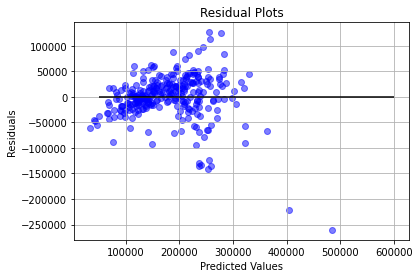

In [46]:
residual_plots(y_test, dt_pred)